# Practica 2: Recurrent Neural Network (RNN))


Las RNN buscan modelar dependencias a largo plazo, conectando información previa con el presente. Para esto cuentan con un mecanismo de retroalimentación.

En esta segunda parte de la practica 2 vamos a implementar una RNN usando Keras para la estimación de valores en una serie de tiempo.

### Importar librerias



In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import sys

##Cargar datos
Primero vamos a cargar una serie de tiempo que se encuentra en el archivo monthly-sunspots.csv.

Las manchas solares son fenómenos temporales en la fotosfera del Sol que aparecen como manchas más oscuras que las zonas circundantes. Son regiones de temperatura superficial reducida causada por concentraciones de flujo de campo magnético que inhiben la convección.

In [30]:
import os

# Obtener la ruta del directorio actual
ruta_actual = os.getcwd()
ruta_padre = os.path.dirname(ruta_actual)
ruta_carpeta_dataset = os.path.join(ruta_padre, "dataset")





c:\Users\jupja\OneDrive\Escritorio\IA\Practica 2\dataset


In [31]:
#Leer datos (solo la segunda columna) en formato float32

df = pd.read_csv(os.path.join(ruta_carpeta_dataset,'monthly-sunspots.csv'),usecols=[1])
data = np.array(df.values.astype('float32'))


#Scalar los datos de 0 a 1 y obtener un arreglo de 1d

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data).flatten()
# Dividir los datos en entrenamiento (80%) y prueba (20%)
n = len(data)
split = int(n*0.8)
train_data = data[range(split)]
test_data = data[split:]

(2256,)


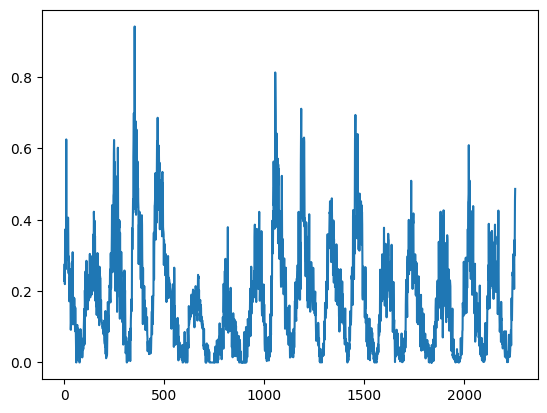

In [32]:
#Visualizar datos de entrenamiento
print(train_data.shape)
plt.plot(train_data)

(564,)


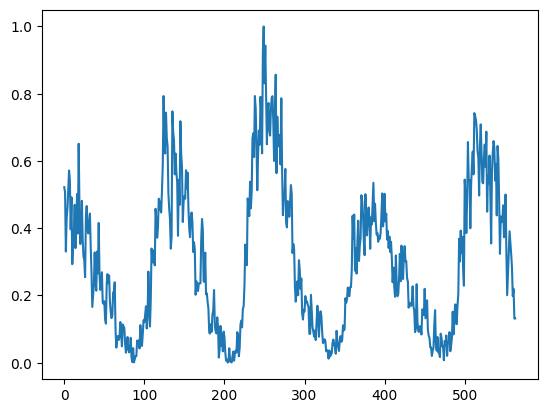

In [33]:
#Visualizar datos de prueba
print(test_data.shape)
plt.plot(test_data)

##Preparación de datos para entrenamiento
El siguiente paso es preparar los datos para el entrenamiento del modelo Keras. El array de entrada debe tener la siguiente forma: total_samples x time_steps x features.

Hay muchas formas de preparar los datos de series temporales para el entrenamiento. Crearemos filas de entrada con pasos de tiempo no solapados.

Un ejemplo para time_steps = 2 sería:

Entrada:

x = [(0,10), (20,30), (40,50)]

t = [(0, 1), ( 2, 3), ( 4, 5)]

Salida:

y = [   20,      40,       60]

t = [    2,       4,        6]

Aquí, time_steps denota el número de pasos de tiempo anteriores a utilizar para predecir el siguiente valor de los datos de series temporales.

La siguiente función permitira construir estos arreglos. Recibiendo los datos y el time_steps. La salida de la función son los vectores X y Y, donde Y es el valor a estimar mediante la red.

*   Usaremos el metodo np.arange(start, stop, step) para generar los indices entre [start, stop) espaciados por time_steps
*   El total de muestras será los datos disponibles / time_steps



In [35]:
#Metodo para construir los conjuntos X y Y de entrenamiento y prueba
def get_XY(dat, time_steps):
    # Indices del arreglo Y
    y_ind = np.arange(time_steps,len(dat),time_steps)
    # Arreglo de los valores a estimar
    Y = dat[y_ind]
    # Organización de X en un arreglo de
    # total_samples x time_steps x features
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X,(rows_x,time_steps,1))
    return X, Y

#Usaremos un time_steps de 12 meses
time_steps = 12
#Organizamos los datos de entrenamiento
trainX, trainY = get_XY(train_data,time_steps)
#Organizamos los datos de prueba
testX,testY = get_XY(test_data,time_steps)

In [36]:
#Revisamos las dimensiones de los conjuntos
print("datos de entrenamiento:")
print("X: ",trainX.shape)
print("Y: ",trainY.shape)

datos de entrenamiento:
X:  (187, 12, 1)
Y:  (187,)


In [41]:
#Revisamos las dimensiones de los conjuntos
print("datos de test:")
print("X: ",testX.shape)
print("Y: ",testY.shape)

datos de test:
X:  (46, 12, 1)
Y:  (46,)


Nota: en este ejemplo estamos usando 12 muestras en el tiempo para estimar un valor de mancha solar.

##Construcción del modelo RNN
Vamos a emplear el modelo secuencial con una RNN, utilizaremos un arquitectura sencilla:


*   Una capa RNN con 3 neuronas ocultas
*   Una capa RNN de salida con 1 neurona para predecir el valor
*   Usaremos la función de activación tanh
*   Asegúrese de establecer return_sequences=True para todas las capas recurrentes (excepto la última, si sólo le interesa la última salida). Sino, la salida será un arreglo 2D (solo con la salida del ultimo paso) en vez de un arreglo 3D (con las salidas de TODOS los pasos). Esto genera un error en las siguientes capas.


In [42]:
#Importar librerias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN


In [44]:
#Configurar el modelo
model = Sequential()

#Capa RNN con 3 neuronas
model.add(SimpleRNN(3, input_shape = (time_steps,1),activation='tanh',return_sequences=True))
#Capa RNN con 1 neurona
model.add(SimpleRNN(1))

c:\Users\jupja\OneDrive\Escritorio\IA\Practica 2\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
#Exploración de la arquitectura
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12, 3)          │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

##Entrenamiento del modelo

In [46]:
#Parametros para entrenamiento
model.compile(optimizer='adam',
              loss='mean_squared_error')
#Entrenamiento
history = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 4s - 19ms/step - loss: 0.3051
Epoch 2/20
187/187 - 1s - 4ms/step - loss: 0.0462
Epoch 3/20
187/187 - 1s - 4ms/step - loss: 0.0285
Epoch 4/20
187/187 - 1s - 4ms/step - loss: 0.0232
Epoch 5/20
187/187 - 1s - 4ms/step - loss: 0.0208
Epoch 6/20
187/187 - 1s - 4ms/step - loss: 0.0193
Epoch 7/20
187/187 - 1s - 4ms/step - loss: 0.0173
Epoch 8/20
187/187 - 1s - 4ms/step - loss: 0.0151
Epoch 9/20
187/187 - 1s - 4ms/step - loss: 0.0140
Epoch 10/20
187/187 - 1s - 4ms/step - loss: 0.0128
Epoch 11/20
187/187 - 1s - 4ms/step - loss: 0.0118
Epoch 12/20
187/187 - 1s - 4ms/step - loss: 0.0108
Epoch 13/20
187/187 - 1s - 4ms/step - loss: 0.0103
Epoch 14/20
187/187 - 1s - 4ms/step - loss: 0.0099
Epoch 15/20
187/187 - 1s - 7ms/step - loss: 0.0090
Epoch 16/20
187/187 - 1s - 4ms/step - loss: 0.0085
Epoch 17/20
187/187 - 1s - 4ms/step - loss: 0.0082
Epoch 18/20
187/187 - 1s - 4ms/step - loss: 0.0078
Epoch 19/20
187/187 - 1s - 4ms/step - loss: 0.0074
Epoch 20/20
187/187 - 1s - 4ms/step - l

##Predicciones con el modelo

In [ ]:
# Aplicar el modelo a datos de prueba
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

2/2 [==============================] - 0s 11ms/step


##Metricas de desempeño

In [ ]:
# Vamos a usar las mismas metricas de la practica 1
from sklearn import metrics

print('MSE: ', metrics.mean_squared_error(testY,test_predict))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(testY,test_predict)))
print('MAE: ', metrics.mean_absolute_error(testY,test_predict))
print('R2_score: ', metrics.r2_score(testY,test_predict))

MSE:  0.024790414
RMSE:  0.15744972
MAE:  0.11275774
R2_score:  0.4628463751745999


##Visualización del resultado

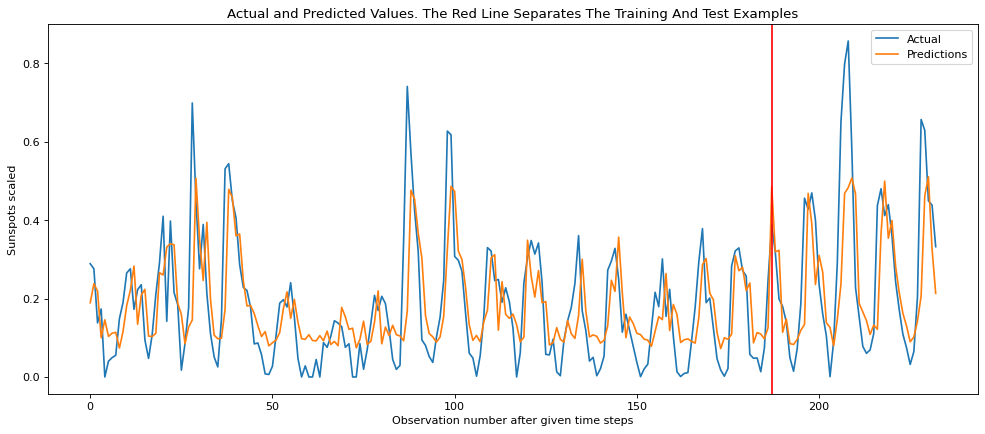

In [ ]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)

## LSTM

In [48]:
from tensorflow.keras.layers import LSTM
#Configurar el modelo
model = Sequential()

#Capa RNN con 3 neuronas
model.add(LSTM(3, input_shape = (time_steps,1),activation='tanh',return_sequences=True))
#Capa RNN con 1 neurona
model.add(LSTM(1))

c:\Users\jupja\OneDrive\Escritorio\IA\Practica 2\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
#Parametros para entrenamiento
model.compile(optimizer='adam',
              loss='mean_squared_error')
#Entrenamiento
history = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 4s - 19ms/step - loss: 0.0254
Epoch 2/20
187/187 - 1s - 4ms/step - loss: 0.0131
Epoch 3/20
187/187 - 1s - 4ms/step - loss: 0.0086
Epoch 4/20
187/187 - 1s - 4ms/step - loss: 0.0059
Epoch 5/20
187/187 - 1s - 4ms/step - loss: 0.0056
Epoch 6/20
187/187 - 1s - 5ms/step - loss: 0.0054
Epoch 7/20
187/187 - 1s - 4ms/step - loss: 0.0052
Epoch 8/20
187/187 - 1s - 4ms/step - loss: 0.0055
Epoch 9/20
187/187 - 1s - 4ms/step - loss: 0.0053
Epoch 10/20
187/187 - 1s - 4ms/step - loss: 0.0053
Epoch 11/20
187/187 - 1s - 4ms/step - loss: 0.0054
Epoch 12/20
187/187 - 1s - 4ms/step - loss: 0.0053
Epoch 13/20
187/187 - 1s - 4ms/step - loss: 0.0052
Epoch 14/20
187/187 - 1s - 4ms/step - loss: 0.0050
Epoch 15/20
187/187 - 1s - 4ms/step - loss: 0.0049
Epoch 16/20
187/187 - 1s - 5ms/step - loss: 0.0051
Epoch 17/20
187/187 - 1s - 4ms/step - loss: 0.0050
Epoch 18/20
187/187 - 1s - 4ms/step - loss: 0.0050
Epoch 19/20
187/187 - 1s - 5ms/step - loss: 0.0051
Epoch 20/20
187/187 - 1s - 5ms/step - l

In [50]:
# Aplicar el modelo a datos de prueba
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [51]:
# Vamos a usar las mismas metricas de la practica 1
from sklearn import metrics

print('MSE: ', metrics.mean_squared_error(testY,test_predict))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(testY,test_predict)))
print('MAE: ', metrics.mean_absolute_error(testY,test_predict))
print('R2_score: ', metrics.r2_score(testY,test_predict))

MSE:  0.010396716
RMSE:  0.10196429
MAE:  0.07855039
R2_score:  0.7747260869462427


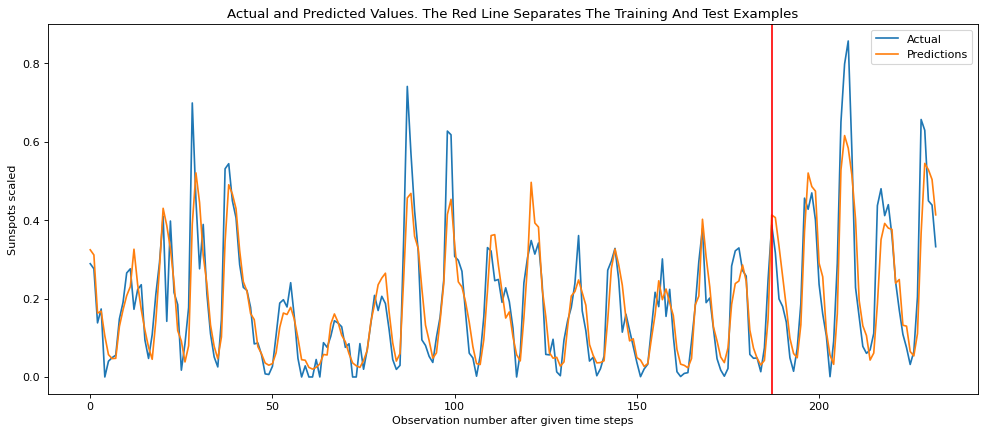

In [52]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)

# ¡Gran trabajo!